# Convolutional Neural Networks

Convolutional Neural Networks (CNN) can be used for image classification (as in part 1 of this notebook) or for image noise reduction (as in part 2 of this notebook). For the former we use CNNs as normal classification functions as in an supervised learning problem. For the latter we use CNNs as autoencoders as in an unsupervised learning problem.

### Auxiliary Functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from numpy.random import randint
from tensorflow.keras.layers import (Activation, Conv2D, Conv2DTranspose,
                                     Dense, Dropout, Flatten, MaxPooling2D)
from tensorflow.keras.models import Sequential

In [2]:
def plt_img(vector, title=None, color="black", pos=None, img_shape=(28, 28, 1)):
    """Auxiliary function for plotting images.

    Args:
        vector (np.array): Array with shape (d,).
        title (str, optional): Title to be displayed above image. Defaults to None.
        color (str, optional): Color of title. Defaults to "black".
        pos (tuple, optional): (n_row, n_col, number) if more than one image should be plotted. Defaults to None.
        img_shape (tuple, optional): Shape of image. Defaults to (28, 28, 1).
    """
    if pos:
        plt.subplot(pos[0], pos[1], pos[2])
    if title:
        plt.title(title, color=color)
    plt.imshow(vector.reshape(img_shape), cmap='gray_r')
    plt.axis('off')

In [3]:
def plt_imgs(array1, array2, n=10):
    """Auxiliary function for plotting pairs of images.

    Args:
        array1 (np.array): Images to draw left image from.
        array2 (np.array): Images to draw right array from.
        n (int, optional): Number of pairs to plot. Defaults to 10.
    """
    indices = np.random.randint(len(array1), size=n)
    imgs1 = array1[indices, :]
    imgs2 = array2[indices, :]

    plt.figure(figsize=(2*n, 4))
    for i, (img1, img2) in enumerate(zip(imgs1, imgs2)):
        ax = plt.subplot(2, n, i + 1)
        plt_img(img1)

        ax = plt.subplot(2, n, i + 1 + n)
        plt_img(img2)

    plt.show()

## Load and Prepare Data

One can use the MNIST or the Fashion-MNIST dataset. 

In [4]:
# load data
# mnist = tf.keras.datasets.mnist
# (x, y), (x_test, y_test) = mnist.load_data()
# classes = np.array([i for i in range(10)])

In [5]:
# fashion_mnist
fashion_mnist = tf.keras.datasets.fashion_mnist
(x, y), (x_test, y_test) = fashion_mnist.load_data()
classes = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

In [6]:
# describe the original data
description = f'''Original data:
x.shape      = {x.shape}
y.shape      = {y.shape}
x_test.shape = {x_test.shape}
y_test.shape = {y_test.shape}
x.dtype      = {x.dtype}
Domain of x-data: [{np.min(x)}, {np.max(x)}]
y.dtype      = {y.dtype}
Domain of y-data: {set(np.unique(y))}'''
print(description)

Original data:
x.shape      = (60000, 28, 28)
y.shape      = (60000,)
x_test.shape = (10000, 28, 28)
y_test.shape = (10000,)
x.dtype      = uint8
Domain of x-data: [0, 255]
y.dtype      = uint8
Domain of y-data: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [7]:
# prepare the data
n, n_test = x.shape[0], x_test.shape[0]
x, x_test = x/255.0, x_test/255.0 # scale
x = x.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

In [8]:
description = f'''Prepared x-data:
x.shape      = {x.shape}
x_test.shape = {x_test.shape}
x.dtype      = {x.dtype}
Domain x-data: [{np.min(x)}, {np.max(x)}]'''
print(description)

prepared x-data:
x.shape      = (60000, 28, 28, 1)
x_test.shape = (10000, 28, 28, 1)
x.dtype      = float64
Domain x-data: [0.0, 1.0]


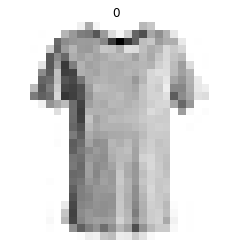

In [9]:
# plot random sample from x-data
r = randint(x.shape[0])
plt_img(x[r,:,:,0], title=y[r])

# CNNs for Image Classification

## Build CNN

Model consisting of two conv2D layers each followed by a pooling layer.

In [10]:
model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = "same", use_bias=False, activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3,3), strides = 1, padding = "same", use_bias=False, activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, use_bias=False, activation='softmax'))  # 10 classes. softmax creates probability-vectors

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        288       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18432     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                31360     
Total params: 50,080
Trainable params: 50,080
Non-trainable params: 0
____________________________________________________

Compile the model with SC-Crossentropy as loss-function and momentum-free Stochastic Gradient Descent as optimizer. 

In [11]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0), 
              metrics = ["accuracy"])

Train the model with 8 epochs using a batch size of 32.

In [12]:
model.fit(x, y, 
          epochs = 8, 
          validation_data = (x_test, y_test), 
          batch_size = 32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.4556 - accuracy: 0.8400 - val_loss: 0.3994 - val_accuracy: 0.8626
Epoch 2/8
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.3063 - accuracy: 0.8917 - val_loss: 0.3158 - val_accuracy: 0.8878
Epoch 3/8
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.2718 - accuracy: 0.9043 - val_loss: 0.2832 - val_accuracy: 0.8972
Epoch 4/8
60000/60000 [==============================] - 60s 1ms/sample - loss: 0.2486 - accuracy: 0.9115 - val_loss: 0.2842 - val_accuracy: 0.9018
Epoch 5/8
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.2322 - accuracy: 0.9179 - val_loss: 0.2906 - val_accuracy: 0.9018
Epoch 6/8
60000/60000 [==============================] - 60s 1ms/sample - loss: 0.2185 - accuracy: 0.9224 - val_loss: 0.2766 - val_accuracy: 0.9056
Epoch 7/8
60000/60000 [==============================] - 60s 9

Calculate accuracy of model on training data and test data.

In [13]:
train_prediction = model.predict(x)
train_accuracy = np.mean(y==np.argmax(train_prediction, axis=1))

test_prediction = model.predict(x_test)
test_accuracy = np.mean(y_test==np.argmax(test_prediction, axis=1))

print(f'train accuracy: {train_accuracy}\ntest  accuracy: {test_accuracy}')

train accuracy: 0.93
test  accuracy: 0.9001


Plot samples with prediction.

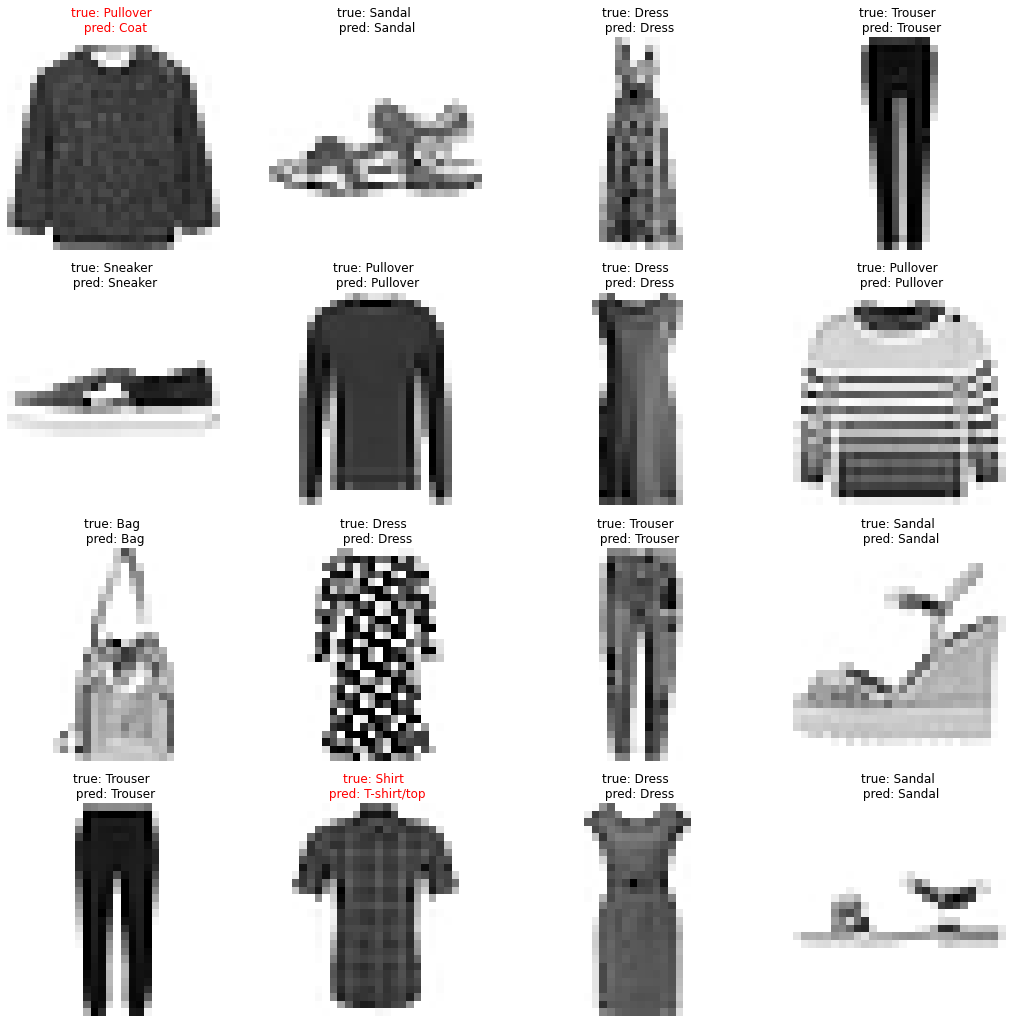

In [14]:
plt.figure(figsize=(18,18))
for i in range(16):
    plt.subplot(4,4,i+1)
    j = np.random.randint(n_test)
    title_text = f'true: {classes[y_test[j]]} \n pred: {classes[np.argmax(test_prediction[j])]}'
    title_color = "black" if (y_test[j] == np.argmax(test_prediction[j])) else "red"
    plt_img(x_test[j,:,:] , title=title_text, color=title_color)
    plt.axis('off')
plt.show()

## Build Simple Model

Model consisting of two dense layers of size 64 and 10 with activation functions _relu_ and _softmax_.

In [15]:
simple_model = Sequential()
simple_model.add(Flatten(input_shape = (28, 28, 1)))
simple_model.add(Dense(64, use_bias=False, activation="relu"))
simple_model.add(Dense(10, use_bias=False, activation='softmax'))

simple_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50176     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                640       
Total params: 50,816
Trainable params: 50,816
Non-trainable params: 0
_________________________________________________________________


Compile the model with SC-Crossentropy as loss-function and momentum-free Stochastic Gradient Descent as optimizer.

In [16]:
simple_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.0),
                     metrics = ["accuracy"])

Train the model with 8 epochs using a batch size of 32.

In [17]:
simple_model.fit(x, y,
                 epochs = 8,
                 validation_data = (x_test, y_test),
                 batch_size = 32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 8s 134us/sample - loss: 0.5573 - accuracy: 0.8009 - val_loss: 0.4948 - val_accuracy: 0.8253
Epoch 2/8
60000/60000 [==============================] - 7s 123us/sample - loss: 0.4144 - accuracy: 0.8504 - val_loss: 0.4143 - val_accuracy: 0.8510
Epoch 3/8
60000/60000 [==============================] - 7s 119us/sample - loss: 0.3789 - accuracy: 0.8635 - val_loss: 0.4063 - val_accuracy: 0.8562
Epoch 4/8
60000/60000 [==============================] - 7s 125us/sample - loss: 0.3545 - accuracy: 0.8718 - val_loss: 0.3939 - val_accuracy: 0.8585
Epoch 5/8
60000/60000 [==============================] - 7s 121us/sample - loss: 0.3375 - accuracy: 0.8770 - val_loss: 0.3977 - val_accuracy: 0.8577
Epoch 6/8
60000/60000 [==============================] - 7s 120us/sample - loss: 0.3243 - accuracy: 0.8819 - val_loss: 0.4071 - val_accuracy: 0.8568
Epoch 7/8
60000/60000 [==============================] -

Calculate accuracy of model on training data and test data.

In [18]:
train_prediction_simple = simple_model.predict(x)
train_accuracy_simple = np.mean(y==np.argmax(train_prediction_simple, axis=1))

test_prediction_simple = simple_model.predict(x_test)
test_accuracy_simple = np.mean(y_test==np.argmax(test_prediction_simple, axis=1))

print(f'train accuracy: {train_accuracy_simple}\ntest  accuracy: {test_accuracy_simple}')

train accuracy: 0.8957333333333334
test  accuracy: 0.871


# CNNs for Image Noise Reduction

## Build Autoencoder using CNNs

Now we use CNNs for image noise reduction. We make use of the Autoencoder framework. The Encoder as well as the Decoder is build using CNNs.

In [19]:
# Encoder
encoder = [
    Conv2D(32, (3,3),
           strides = 1,
           padding = "same",
           activation = 'relu',
           input_shape = (28, 28, 1)
          ),
    MaxPooling2D((2, 2),
                 padding="same"
                ),
    Conv2D(32, (3,3),
           strides = 1,
           padding = "same",
           activation = 'relu'
          ),
    MaxPooling2D((2, 2),
                 padding="same"
                )
]
# Decoder
decoder = [
    Conv2DTranspose(32, (3, 3),
                    strides=2,
                    activation="relu",
                    padding="same"
                   ),
    Conv2DTranspose(32, (3, 3),
                    strides=2,
                    activation="relu",
                    padding="same"
                   ),
    Conv2D(1, (3, 3),
           activation="sigmoid",
           padding="same"
          )
]

layers = encoder + decoder

autoencoder = Sequential(layers)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.build()
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 1)        

In [20]:
autoencoder.fit(x, x, epochs = 1, validation_data = (x_test, x_test), batch_size = 128)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.3055 - val_loss: 0.2726


In [21]:
def display(array1, array2, indices):
    
    n = len(indices)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

def noise(array):
    noise_factor = 0.3
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

In [22]:
indices = np.random.randint(len(x_test), size=n)

In [ ]:
predictions = autoencoder.predict(x_test)
display(x_test, predictions, indices)

In [ ]:
x_test_noise = noise(x_test)
display(x_test, x_test_noise)

In [ ]:
pred_noise = autoencoder.predict(x_test_noise)
display(x_test_noise, pred_noise)